**The following notebook is to demonstrate how the training of the SimpleHTR's CRNN-CTC model was fine-tuned on Armenian dataset. Please don't execute the cells as they are computationally heavy. Necessary informations are provided throughout the process to understand properly how the fine-tuning was done.**

# Imports

# Simple inference example on original model

In [ ]:
import os
import time
import cv2
import json
import mlflow
import editdistance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import tensorflow as tf
from src.dataloader_arm import DataLoaderARM, Batch
from src.dataloader_iam import DataLoaderIAM
from src.model import Model, DecoderType
from src.preprocessor import Preprocessor
from src.main import validate
from src.train import train_model
import re

In [2]:
# this is the character list, as this is just an inference stage here its still eng letters (+nums, some other chars)
with open("model/charList.txt") as f:
    char_list = list(f.read())

In [ ]:
char_list 

[' ',
 '!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
decoder_type = DecoderType.BestPath  # this was like that in main.py
tf.compat.v1.reset_default_graph()
model = Model(
    char_list,
    decoder_type=decoder_type,
    must_restore=True,  # remember!! must_restore = True means it loads from a checkpoint
    specified_model_path="./model/",  #!! added a new parameter to point to the fine-tuned model dir
)

Python: 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Tensorflow: 2.4.0
[DEBUG] Looking for model in: c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model
Init with stored values from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model\snapshot-33
INFO:tensorflow:Restoring parameters from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model\snapshot-33


In [7]:
img_path = "./data/word.png"  # their provided iam word example
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

In [42]:
'''def get_img_height() -> int:
    """Fixed height for NN."""
    return 32


def get_img_size(line_mode: bool = False) -> Tuple[int, int]:
    """Height is fixed for NN, width is set according to training mode (single words or text lines)."""
    if line_mode:
        return 256, get_img_height()
    return 128, get_img_height()'''

'def get_img_height() -> int:\n    """Fixed height for NN."""\n    return 32\n\n\ndef get_img_size(line_mode: bool = False) -> Tuple[int, int]:\n    """Height is fixed for NN, width is set according to training mode (single words or text lines)."""\n    if line_mode:\n        return 256, get_img_height()\n    return 128, get_img_height()'

In [8]:
# see above how these were defined in main, I just hardcoded the word-level values here for sizes
# the padding = 16 was also from there
preprocessor = Preprocessor(img_size=(128, 32), dynamic_width=True, padding=16)
img = preprocessor.process_img(img)
batch = Batch([img], None, 1)

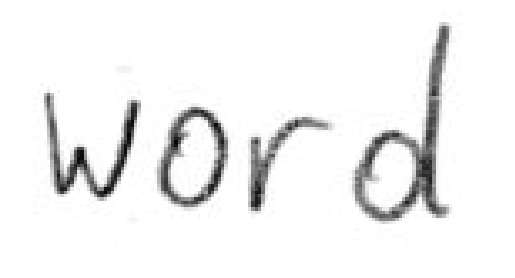

In [ ]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [9]:
recognized, probability = model.infer_batch(batch, calc_probability=True)
print("Recognized:", recognized[0])
print("Probability:", probability[0])

Recognized: word
Probability: 0.951384


In [ ]:
# exploring the model architecture, it can be seen that Variable 5:0 is the projection layer
# it has to be dropped and re-initialized to map to Armenain char_list
for v in tf.compat.v1.global_variables():
    print(v.name, v.shape)

Variable:0 (5, 5, 1, 32)
batch_normalization/gamma:0 (32,)
batch_normalization/beta:0 (32,)
batch_normalization/moving_mean:0 (32,)
batch_normalization/moving_variance:0 (32,)
Variable_1:0 (5, 5, 32, 64)
batch_normalization_1/gamma:0 (64,)
batch_normalization_1/beta:0 (64,)
batch_normalization_1/moving_mean:0 (64,)
batch_normalization_1/moving_variance:0 (64,)
Variable_2:0 (3, 3, 64, 128)
batch_normalization_2/gamma:0 (128,)
batch_normalization_2/beta:0 (128,)
batch_normalization_2/moving_mean:0 (128,)
batch_normalization_2/moving_variance:0 (128,)
Variable_3:0 (3, 3, 128, 128)
batch_normalization_3/gamma:0 (128,)
batch_normalization_3/beta:0 (128,)
batch_normalization_3/moving_mean:0 (128,)
batch_normalization_3/moving_variance:0 (128,)
Variable_4:0 (3, 3, 128, 256)
batch_normalization_4/gamma:0 (256,)
batch_normalization_4/beta:0 (256,)
batch_normalization_4/moving_mean:0 (256,)
batch_normalization_4/moving_variance:0 (256,)
bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel

# Fine-tuning

### defining a training function like in main.py but adapting it to personal preferences

In [ ]:
def train(
    model,
    loader,
    preprocessor,
    run_name="HTR-Experiment",
    checkpoint_dir="./checkpoints/",
    summary_path="./summary.json",
    early_stopping=25,
    max_epochs=100,
    line_mode=False,
    compute_val_loss=False,
):
    """
    Train a Handwritten Text Recognition (HTR) model with support for MLflow logging,
    early stopping, and optional validation loss tracking.

    Parameters:
    ----------
    model : src.model.Model
        The HTR model to be trained.

    loader : DataLoaderARM
        Data loader that provides training and validation batches.

    preprocessor : Preprocessor
        Preprocessing utility to normalize and prepare batches.

    run_name : str, optional
        Name of the MLflow run (default: "HTR-Experiment").

    checkpoint_dir : str, optional
        Directory where model checkpoints will be saved (default: './checkpoints/').

    summary_path : str, optional
        Path to save the JSON summary of training metrics (default: './summary.json').

    early_stopping : int, optional
        Number of epochs to wait without improvement before stopping training (default: 25).

    max_epochs : int, optional
        Maximum number of epochs to train for (default: 100).

    line_mode : bool, optional
        If True, trains and validates in line-level mode; otherwise, word-level (default: False).

    compute_val_loss : bool, optional
        Whether to calculate validation loss per epoch in addition to error metrics (default: False).

    Logs:
    ----
    - Training and validation Character Error Rate (CER) and Word Accuracy Rate (WAR).
    - Average training loss per epoch.
    - (Optional) Validation loss per epoch.
    - Model checkpoints and training summary JSON file.
    - Total training duration.

    Notes:
    -----
    - Requires MLflow to be configured beforehand.
    - Automatically handles checkpointing the best-performing model based on CER.
    - Uses `validate()` function for metric computation and supports early stopping.
    """

    epoch = 0
    no_improvement_since = 0
    best_char_error_rate = float("inf")

    summary_char_error_rates = []
    summary_word_accuracies = []
    summary_train_word_accuracies = []
    summary_train_char_error_rates = []
    average_train_loss = []
    val_losses = []

    os.makedirs(checkpoint_dir, exist_ok=True)

    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("batch_size", loader.batch_size)
        mlflow.log_param("early_stopping", early_stopping)
        mlflow.log_param("max_epochs", max_epochs)
        mlflow.log_param("line_mode", line_mode)
        mlflow.log_param("char_list_length", len(model.char_list))
        mlflow.log_param("decoder_type", model.decoder_type)
        mlflow.log_param("compute_val_loss", compute_val_loss)

        start_time = time.time()

        while epoch < max_epochs:
            epoch += 1
            print(f"\nEpoch {epoch}")
            loader.train_set()
            train_loss_in_epoch = []

            while loader.has_next():
                batch = loader.get_next()
                batch = preprocessor.process_batch(batch)
                loss = model.train_batch(batch)
                train_loss_in_epoch.append(loss)

            avg_train_loss = sum(train_loss_in_epoch) / len(train_loss_in_epoch)
            average_train_loss.append(avg_train_loss)
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            print(f"Average Training Loss: {avg_train_loss:.4f}")

            train_cer, train_war = validate(
                model, loader, line_mode=line_mode, is_train=True
            )
            summary_train_char_error_rates.append(train_cer)
            summary_train_word_accuracies.append(train_war)
            mlflow.log_metric("train_cer", train_cer, step=epoch)
            mlflow.log_metric("train_war", train_war, step=epoch)
            print(f"Train CER: {train_cer:.4f} | Train WAR: {train_war:.4f}")

            cer, word_acc = validate(model, loader, line_mode=line_mode, is_train=False)
            summary_char_error_rates.append(cer)
            summary_word_accuracies.append(word_acc)
            mlflow.log_metric("val_cer", cer, step=epoch)
            mlflow.log_metric("val_war", word_acc, step=epoch)
            # print(f'Validation CER: {cer:.4f} | Validation WAR: {word_acc:.4f}')
            print(
                f"Validation CER: {cer * 100:.2f}% | Validation Word Accuracy: {word_acc * 100:.2f}%"
            )

            if compute_val_loss:
                loader.validation_set()
                val_loss_in_epoch = []
                while loader.has_next():
                    batch = loader.get_next()
                    batch = preprocessor.process_batch(batch)
                    val_loss = model.validate_batch(batch)
                    val_loss_in_epoch.append(val_loss)
                avg_val_loss = sum(val_loss_in_epoch) / len(val_loss_in_epoch)
                val_losses.append(avg_val_loss)
                mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
                print(f"Validation Loss: {avg_val_loss:.4f}")

            if cer < best_char_error_rate:
                best_char_error_rate = cer
                no_improvement_since = 0
                model.save(checkpoint_dir)
                print("Character error rate improved. Model saved.")
            else:
                no_improvement_since += 1
                print(
                    f"No improvement. Patience: {no_improvement_since}/{early_stopping}"
                )

            if no_improvement_since >= early_stopping:
                print("Early stopping triggered.")
                break

        summary = {
            "averageTrainLoss": average_train_loss,
            "trainCharErrorRates": summary_train_char_error_rates,
            "trainWordAccuracies": summary_train_word_accuracies,
            "valCharErrorRates": summary_char_error_rates,
            "valWordAccuracies": summary_word_accuracies,
        }

        if compute_val_loss:
            summary["averageValLoss"] = val_losses

        with open(summary_path, "w", encoding="utf-8") as f:
            json.dump(summary, f, ensure_ascii=False)

        mlflow.log_artifact(summary_path)
        mlflow.log_artifacts(checkpoint_dir, artifact_path="checkpoints")

        duration = time.time() - start_time
        mlflow.log_metric("total_training_time_sec", duration)
        print(f"Training complete in {duration:.2f} seconds.")

In [ ]:
print("TF version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices("GPU")) #checking gpu availability

TF version: 2.4.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Setting up the data (Synthetic + Real)

In [ ]:
df_synthetic = pd.read_csv(
    "data/annotations_synthetic.tsv", sep="\t", header=None, names=["img", "label"]
)
df_synthetic["img"] = "data/synthetic_words_inverted/" + df_synthetic["img"].astype(str)

df_augmented = pd.read_csv(
    "data/annotations_augmented.txt", sep="\t", header=None, names=["img", "label"]
)
df_augmented["img"] = "data/cropped_words/" + df_augmented["img"].astype(str)

df_merged = pd.concat([df_synthetic, df_augmented], ignore_index=True)

In [ ]:
with open("model_checkpoints_armo/charList.txt", encoding="utf-8") as f:
    char_list_armo = list(f.read())

In [ ]:
# important to see if the dataset has all of its character labels from the defined charlist
def is_valid_label(label):
    return (
        isinstance(label, str)
        and all(c in char_list_armo for c in label)
        and " " not in label
    )

In [ ]:
df_merged = pd.read_csv(
    "data/annotations_full.txt", sep=" ", header=None, names=["img", "label"]
)

In [ ]:
df_merged = df_merged.dropna(subset=["label"])
df_merged = df_merged[df_merged["label"].apply(is_valid_label)]
df_merged = df_merged[df_merged["img"].apply(os.path.exists)]

In [ ]:
len(df_merged)

77854

In [ ]:
# saving the final annotations file
df_merged.to_csv("data/annotations_full.txt", sep=" ", header=False, index=False)

## Dataloader and Model Setup

In [ ]:
data_dir = Path("./")
# the dataloader 
loader = DataLoaderARM(
    data_dir=data_dir,
    batch_size=10,
    annot_path="data/annotations_full.txt",  # just as saved before
    fast=False,
) 

In [ ]:
print(len(loader.train_samples))
print(len(loader.validation_samples))
print(len(loader.test_samples))  # 80-10-10 split

62283
7785
7786


**set up the logging in terminal using the below command**

In [ ]:
mlflow ui --backend-store-uri SimpleHTR/mlruns

^C


In [ ]:
with open("model_checkpoints_armo/charList.txt", encoding="utf-8") as f:
    char_list_armo = list(f.read())

In [ ]:
tf.compat.v1.reset_default_graph()
model_armo = Model(
    char_list=char_list_armo,
    decoder_type=DecoderType.BestPath,
    must_restore=True,
    fine_tune=True,
    specified_model_path="model_checkpoints_armo/",
) #initializing the Model WITH fine_tuning = true to drop the last layer and re-initialize it

c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Python: 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Tensorflow: 2.4.0
[DEBUG] Looking for model in: c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo
Init with stored values from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5
INFO:tensorflow:Restoring parameters from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5


make sure the projection layer is `Variable_5:0` is now showing the new number of characters in char list (previously 80)

In [ ]:
for v in tf.compat.v1.global_variables():
    print(v.name, v.shape)

Variable:0 (5, 5, 1, 32)
batch_normalization/gamma:0 (32,)
batch_normalization/beta:0 (32,)
batch_normalization/moving_mean:0 (32,)
batch_normalization/moving_variance:0 (32,)
Variable_1:0 (5, 5, 32, 64)
batch_normalization_1/gamma:0 (64,)
batch_normalization_1/beta:0 (64,)
batch_normalization_1/moving_mean:0 (64,)
batch_normalization_1/moving_variance:0 (64,)
Variable_2:0 (3, 3, 64, 128)
batch_normalization_2/gamma:0 (128,)
batch_normalization_2/beta:0 (128,)
batch_normalization_2/moving_mean:0 (128,)
batch_normalization_2/moving_variance:0 (128,)
Variable_3:0 (3, 3, 128, 128)
batch_normalization_3/gamma:0 (128,)
batch_normalization_3/beta:0 (128,)
batch_normalization_3/moving_mean:0 (128,)
batch_normalization_3/moving_variance:0 (128,)
Variable_4:0 (3, 3, 128, 256)
batch_normalization_4/gamma:0 (256,)
batch_normalization_4/beta:0 (256,)
batch_normalization_4/moving_mean:0 (256,)
batch_normalization_4/moving_variance:0 (256,)
bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel

In [ ]:
preprocessor = Preprocessor(
    img_size=(128, 32), data_augmentation=False, line_mode=False
)  # loading preprocessor

In [ ]:
batch = loader.get_next()
print("Batch size:", batch.batch_size)
print("Image shape:", batch.imgs[0].shape)
print("Labels:", batch.gt_texts)

Batch size: 10
Image shape: (53, 62)
Labels: ['էր', 'հիդրոկայաններ', 'պետք', 'բան', 'եմ', 'Ցիցիլիա', 'ոճիրը', 'Երեքշաբթին', 'ձիթապտղամոխրագույն', 'որում']


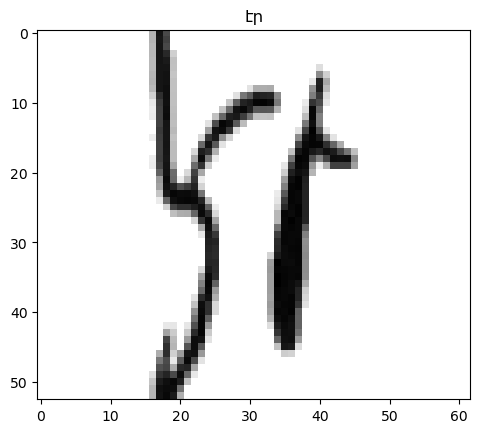

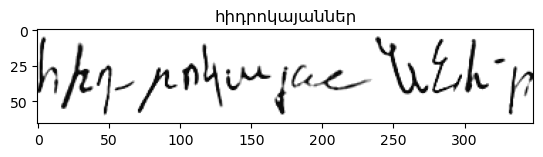

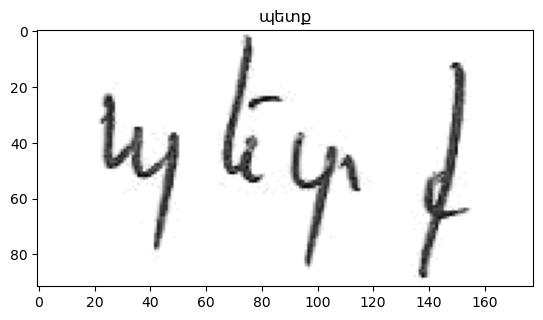

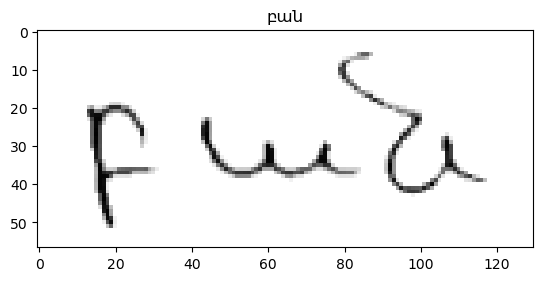

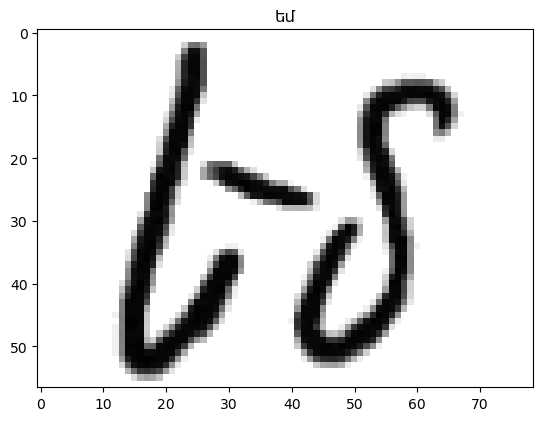

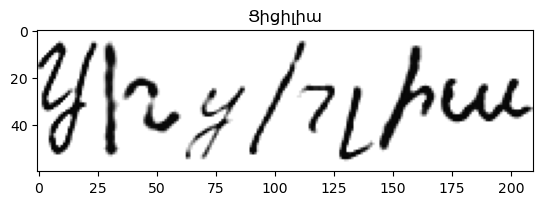

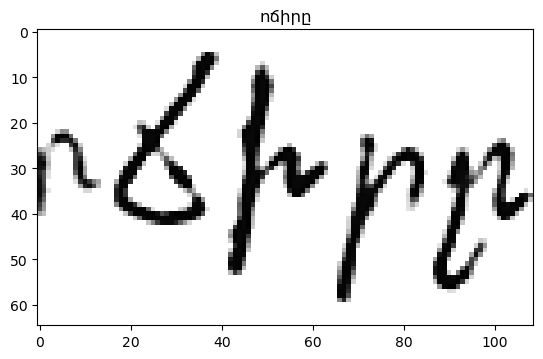

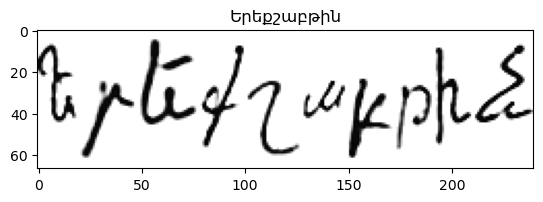

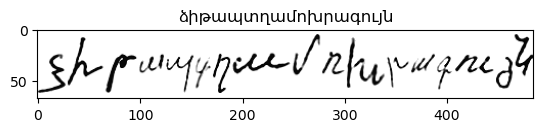

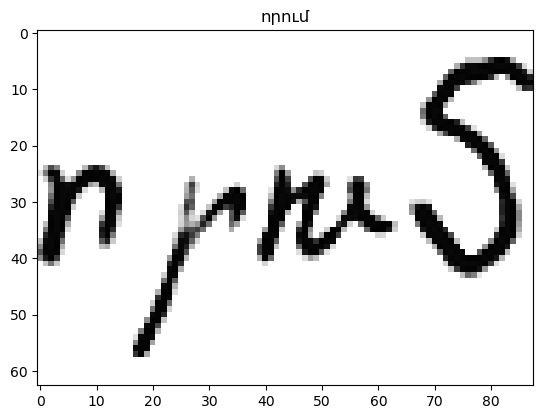

In [ ]:
for i in range(batch.batch_size):
    plt.imshow(batch.imgs[i], cmap="gray")
    plt.title(batch.gt_texts[i])
    plt.show()

In [ ]:
data_dir = Path("./")
loader = DataLoaderARM(
    data_dir=data_dir,
    batch_size=100,
    annot_path="data/annotations_full.txt",  # just as saved before
    fast=False,
)

can observe properties of the training function if needed

In [ ]:
?? train_model

Signature:
 train_model(
    model,
    loader,
    preprocessor,
    run_name='HTR-Experiment',
    checkpoint_dir='./checkpoints/',
    summary_path='./summary.json',
    early_stopping=25,
    max_epochs=100,
    line_mode=False,
    compute_val_loss=False,
)
Source:   
def train_model(model,
          loader,
          preprocessor,
          run_name="HTR-Experiment",
          checkpoint_dir='./checkpoints/',
          summary_path='./summary.json',
          early_stopping=25,
          max_epochs=100,
          line_mode=False,
          compute_val_loss=False):
    
    """Trains NN with MLflow logging."""

    epoch = 0
    no_improvement_since = 0
    best_char_error_rate = float('inf')

    summary_char_error_rates = []
    summary_word_accuracies = []
    summary_train_word_accuracies = []
    summary_train_char_error_rates = []
    average_train_loss = []
    val_losses = []

    os.makedirs(checkpoint_dir, exist_ok=True)

    with mlflow.start_run(run_name=run_name):
   

In [ ]:
train_model(
    model=model_armo,
    loader=loader,
    preprocessor=preprocessor,
    checkpoint_dir="./model_checkpoints_armo/",
    summary_path="./armo_training_tuning_summary.json",
    early_stopping=10,
    max_epochs=40,
    line_mode=False,
    compute_val_loss=True,
    run_name="SimpleHTR-armo-tuning-2",
)


Epoch 1
Average Training Loss: 3.2325
Validate NN (Train)
Batch: 1 / 622
Running an inference
Batch: 2 / 622
Running an inference
Batch: 3 / 622
Running an inference
Batch: 4 / 622
Running an inference
Batch: 5 / 622
Running an inference
Batch: 6 / 622
Running an inference
Batch: 7 / 622
Running an inference
Batch: 8 / 622
Running an inference
Batch: 9 / 622
Running an inference
Batch: 10 / 622
Running an inference
Batch: 11 / 622
Running an inference
Batch: 12 / 622
Running an inference
Batch: 13 / 622
Running an inference
Batch: 14 / 622
Running an inference
Batch: 15 / 622
Running an inference
Batch: 16 / 622
Running an inference
Batch: 17 / 622
Running an inference
Batch: 18 / 622
Running an inference
Batch: 19 / 622
Running an inference
Batch: 20 / 622
Running an inference
Batch: 21 / 622
Running an inference
Batch: 22 / 622
Running an inference
Batch: 23 / 622
Running an inference
Batch: 24 / 622
Running an inference
Batch: 25 / 622
Running an inference
Batch: 26 / 622
Running a

In [ ]:
tf.compat.v1.reset_default_graph()
model_best = Model(
    char_list=char_list_armo,
    must_restore=True,
    fine_tune=False,
    specified_model_path="model_checkpoints_armo/",
)

c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Python: 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Tensorflow: 2.4.0
[DEBUG] Looking for model in: c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo
Init with stored values from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5
INFO:tensorflow:Restoring parameters from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5


In [ ]:
def evaluate_model_on_test_set(model, loader, preprocessor):
    """
    Run inference on the test set using the provided model and calculate evaluation metrics.

    Args:
        model (Model): Trained handwriting recognition model to evaluate.
        loader (DataLoaderARM): DataLoader instance for the dataset with test set loaded via `loader.test_set()`.
        preprocessor (Preprocessor): Preprocessor instance for preparing batches.

    Returns:
        tuple: (char_error_rate, word_accuracy)
            - char_error_rate (float): Total character-level error rate over the test set.
            - word_accuracy (float): Proportion of perfectly recognized words in the test set.
    """
    loader.test_set()
    num_char_err = 0
    num_char_total = 0
    num_word_ok = 0
    num_word_total = 0

    while loader.has_next():
        iter_info = loader.get_iterator_info()
        print(f"Batch: {iter_info[0]} / {iter_info[1]}")
        batch = loader.get_next()
        batch = preprocessor.process_batch(batch)
        recognized, _ = model.infer_batch(batch)
        print("Running an inference")
        for i in range(len(recognized)):
            num_word_ok += 1 if batch.gt_texts[i] == recognized[i] else 0
            num_word_total += 1
            dist = editdistance.eval(recognized[i], batch.gt_texts[i])
            num_char_err += dist
            num_char_total += len(batch.gt_texts[i])

    char_error_rate = num_char_err / num_char_total
    word_accuracy = num_word_ok / num_word_total
    print(f"Character error rate: {char_error_rate * 100.0}%. Word accuracy: {word_accuracy * 100.0}%.")

    return char_error_rate, word_accuracy

In [ ]:
char_error_rate, word_accuracy = evaluate_model_on_test_set(model_best, loader, preprocessor)

Batch: 1 / 78
Running an inference
Batch: 2 / 78
Running an inference
Batch: 3 / 78
Running an inference
Batch: 4 / 78
Running an inference
Batch: 5 / 78
Running an inference
Batch: 6 / 78
Running an inference
Batch: 7 / 78
Running an inference
Batch: 8 / 78
Running an inference
Batch: 9 / 78
Running an inference
Batch: 10 / 78
Running an inference
Batch: 11 / 78
Running an inference
Batch: 12 / 78
Running an inference
Batch: 13 / 78
Running an inference
Batch: 14 / 78
Running an inference
Batch: 15 / 78
Running an inference
Batch: 16 / 78
Running an inference
Batch: 17 / 78
Running an inference
Batch: 18 / 78
Running an inference
Batch: 19 / 78
Running an inference
Batch: 20 / 78
Running an inference
Batch: 21 / 78
Running an inference
Batch: 22 / 78
Running an inference
Batch: 23 / 78
Running an inference
Batch: 24 / 78
Running an inference
Batch: 25 / 78
Running an inference
Batch: 26 / 78
Running an inference
Batch: 27 / 78
Running an inference
Batch: 28 / 78
Running an inference
B

In [47]:
def predict_on_split(model, loader, preprocessor, split: str):
    """
    Run inference on a specified data split ('train', 'val', or 'test') and return a DataFrame.
    """
    assert split in ["train", "val", "test"], "Split must be 'train', 'val', or 'test'"

    # take the chosen set
    if split == "train":
        loader.train_set()
    elif split == "val":
        loader.validation_set()
    elif split == "test":
        loader.test_set()

    predictions = []
    ground_truths = []
    image_paths = []

    while loader.has_next():
        start_idx = loader.curr_idx
        batch = loader.get_next()
        end_idx = loader.curr_idx
        batch_sample_indices = list(range(start_idx, end_idx))

        valid_data = [
            (i, img, batch.gt_texts[i])
            for i, img in enumerate(batch.imgs)
            if img is not None
        ]

        if not valid_data:
            continue

        valid_imgs = [img for _, img, _ in valid_data]
        valid_gt_texts = [gt for _, _, gt in valid_data]
        valid_paths = [
            str(loader.samples[batch_sample_indices[i]].file_path)
            for i, _, _ in valid_data
        ]

        processed_imgs = [preprocessor.process_img(img) for img in valid_imgs]
        batch_processed = Batch(processed_imgs, valid_gt_texts, len(valid_imgs))

        pred, _ = model.infer_batch(batch_processed)

        predictions.extend(pred)
        ground_truths.extend(valid_gt_texts)
        image_paths.extend(valid_paths)

    df_results = pd.DataFrame(
        {
            "image_path": image_paths,
            "ground_truth": ground_truths,
            "prediction": predictions,
            "correct": [gt == pr for gt, pr in zip(ground_truths, predictions)],
        }
    )

    return df_results

In [ ]:
df_train = predict_on_split(model_best, loader, preprocessor, split="train")
df_val = predict_on_split(model_best, loader, preprocessor, split="val")
df_test = predict_on_split(model_best, loader, preprocessor, split="test")

In [ ]:
df_train.to_csv("./data/train_results.csv")
df_val.to_csv("./data/validation_results.csv")
df_test.to_csv("./data/test_results.csv")

In [ ]:
df_train.head(20)

,image_path,ground_truth,prediction,correct
0,data\synthetic_words_inverted\56\arm_47203.png,ղեկավարությանն,ղեկավարությանն,True
1,data\cropped_words\IMG_044-2_word_24_augmented...,էր,էր,True
2,data\cropped_words\IMG_20250316_0002-17_word_9...,եք,եք,True
3,data\cropped_words\IMG_044-2_word_65.png,"այժմ,","այժմ,",True
4,data\synthetic_words_inverted\77\arm_33784.png,ֆիբրոպլաստներն,ֆիբրոպլաստներն,True
5,data\cropped_words\IMG_302-21_word_79_augmente...,նրան,նրան,True
6,data\cropped_words\IMG_302-03_word_42_augmente...,թերթերը,թերթերը,True
7,data\synthetic_words_inverted\14\arm_45234.png,Կարմայքլի,Կարմայքլի,True
8,data\synthetic_words_inverted\41\arm_16969.png,գզրարներ,գզրարներ,True
9,data\cropped_words\IMG_301-05_word_85_augmente...,բառապաշարս,բառապաշարս,True


In [ ]:
df_val.head(20)

,image_path,ground_truth,prediction,correct
0,data\synthetic_words_inverted\39\arm_6738.png,ացտեկներին,ացտեկներին,True
1,data\cropped_words\IMG_20250314_0001-24_word_1...,Կարող,Կարող,True
2,data\synthetic_words_inverted\6\arm_49073.png,Էլիսոնի,Էլիսոնի,True
3,data\synthetic_words_inverted\22\arm_35600.png,Շտիրումը,Շտիրումը,True
4,data\synthetic_words_inverted\20\arm_43941.png,Յակիմովը,Յակիմովը,True
5,data\synthetic_words_inverted\74\arm_11317.png,քարշուժ,քարշուժ,True
6,data\cropped_words\IMG_302-19_word_75_augmente...,Եթե,Եթե,True
7,data\synthetic_words_inverted\0\arm_13563.png,Ասպիսակից,Ասպիսակից,True
8,data\synthetic_words_inverted\6\arm_49241.png,Էթրեն,Էթրեն,True
9,data\cropped_words\IMG_20250314_0001-22_word_1...,միավորեց,միավորեց,True


In [ ]:
df_test.head(20)

,image_path,ground_truth,prediction,correct
0,data\synthetic_words_inverted\67\arm_30791.png,ռադիոալիքներից,հացիոսլիքներից,False
1,data\cropped_words\IMG_301-05_word_98_augmente...,կարողանում,կարողանում,True
2,data\synthetic_words_inverted\49\arm_2976.png,ինտերնացիստական,ինտերնացիստական,True
3,data\synthetic_words_inverted\12\arm_42999.png,Խուրին,Խուրին,True
4,data\synthetic_words_inverted\67\arm_30946.png,ռազմածառյողներից,ռազմածառյողներից,True
5,data\synthetic_words_inverted\71\arm_50154.png,րաստենիյ,բաստենիյ,False
6,data\cropped_words\IMG_301-19_word_93_augmente...,պետք,պետք,True
7,data\synthetic_words_inverted\0\arm_13139.png,Արդյունաբերությունների,Արդյունաբերությունների,True
8,data\cropped_words\IMG_20250314_0001-16_word_5...,ես,ես,True
9,data\synthetic_words_inverted\29\arm_19348.png,Սուրյավարման,Սուրյավարման,True


In [ ]:
validate(model=model_best, loader=loader, line_mode=False, is_train=True)

Validate NN (Train)
Batch: 1 / 622
Running an inference
Batch: 2 / 622
Running an inference
Batch: 3 / 622
Running an inference
Batch: 4 / 622
Running an inference
Batch: 5 / 622
Running an inference
Batch: 6 / 622
Running an inference
Batch: 7 / 622
Running an inference
Batch: 8 / 622
Running an inference
Batch: 9 / 622
Running an inference
Batch: 10 / 622
Running an inference
Batch: 11 / 622
Running an inference
Batch: 12 / 622
Running an inference
Batch: 13 / 622
Running an inference
Batch: 14 / 622
Running an inference
Batch: 15 / 622
Running an inference
Batch: 16 / 622
Running an inference
Batch: 17 / 622
Running an inference
Batch: 18 / 622
Running an inference
Batch: 19 / 622
Running an inference
Batch: 20 / 622
Running an inference
Batch: 21 / 622
Running an inference
Batch: 22 / 622
Running an inference
Batch: 23 / 622
Running an inference
Batch: 24 / 622
Running an inference
Batch: 25 / 622
Running an inference
Batch: 26 / 622
Running an inference
Batch: 27 / 622
Running an 

(0.0076878739752611345, 0.9478617363344052)

In [ ]:
validate(model=model_best, loader=loader, line_mode=False, is_train=False)

Validate NN (Val)
Batch: 1 / 78
Running an inference
Batch: 2 / 78
Running an inference
Batch: 3 / 78
Running an inference
Batch: 4 / 78
Running an inference
Batch: 5 / 78
Running an inference
Batch: 6 / 78
Running an inference
Batch: 7 / 78
Running an inference
Batch: 8 / 78
Running an inference
Batch: 9 / 78
Running an inference
Batch: 10 / 78
Running an inference
Batch: 11 / 78
Running an inference
Batch: 12 / 78
Running an inference
Batch: 13 / 78
Running an inference
Batch: 14 / 78
Running an inference
Batch: 15 / 78
Running an inference
Batch: 16 / 78
Running an inference
Batch: 17 / 78
Running an inference
Batch: 18 / 78
Running an inference
Batch: 19 / 78
Running an inference
Batch: 20 / 78
Running an inference
Batch: 21 / 78
Running an inference
Batch: 22 / 78
Running an inference
Batch: 23 / 78
Running an inference
Batch: 24 / 78
Running an inference
Batch: 25 / 78
Running an inference
Batch: 26 / 78
Running an inference
Batch: 27 / 78
Running an inference
Batch: 28 / 78
Runn

(0.03699439327192631, 0.8055234425176622)

# Setting up Armenian Corpus

using the same logic as before extract the Armenian words (full list now)

In [ ]:
text_file = "../data_preparation/hye_wikipedia_2021_1M-words.txt"

ARMENIAN_LETTERS = (
    "ԱԲԳԴԵԶԷԸԹԺԻԼԽԾԿՀՁՂՃՄՅՆՇՈՉՊՋՌՍՎՏՐՑՒՓՔՕՖ"
    + "աբգդեզէըթժիլխծկհձղճմյունշոչպջռսվտրցւփքօֆև"
)

# normalizing "ւ"/"Ւ" to "ու"/"ՈՒ" in words


def normalize_word(word):
    word = re.sub(r"(?<![Ոո])Ւ", "ՈՒ", word)
    word = re.sub(r"(?<![ոՈ])ւ", "ու", word)
    return word


cleaned_words = []
with open(text_file, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) < 2:
            continue

        word = normalize_word(parts[1])

        if not all(
            char in ARMENIAN_LETTERS
            for char in word.replace("ու", "").replace("ՈՒ", "")
        ):
            continue

        cleaned_words.append(word)

print(f"Found {len(cleaned_words)} valid Armenian words")

Found 628626 valid Armenian words


In [ ]:
with open("data/corpus.txt", "w", encoding="utf-8") as f:
    f.write(" ".join(cleaned_words))

**IMPORTANT** Here your absolute path to `CTCWordBeamSearch\build\lib.win-amd64-3.8` should be set, to be able to use the WBS in the code

In [ ]:
current = Path().resolve()
target_dir = None

while current != current.parent:  # stop at filesystem root
    candidate = current / "CTCWordBeamSearch" / "build"
    if candidate.exists():
        for subdir in candidate.iterdir():
            if subdir.is_dir() and "lib.win-amd64-3.8" in subdir.name:
                target_dir = subdir.resolve()
                break
        if target_dir:
            break
    current = current.parent

if target_dir:
    print("Absolute path:", target_dir)
    sys.path.append(str(target_dir))
else:
    print("Target directory not found.")

In [ ]:
import sys
sys.path.append(target_dir)
from word_beam_search import WordBeamSearch

In [ ]:
import importlib
import src.model
importlib.reload(src.model)
from src.model import Model, DecoderType

In [ ]:
tf.compat.v1.reset_default_graph()
model_best_wbs = Model(
    char_list=char_list_armo,
    decoder_type=DecoderType.WordBeamSearch,
    must_restore=True,
    fine_tune=False,
    specified_model_path="model_checkpoints_armo",
)

Python: 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Tensorflow: 2.4.0
[DEBUG] Looking for model in: c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo
Init with stored values from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5
INFO:tensorflow:Restoring parameters from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5


In [ ]:
validate(model=model_best_wbs, loader=loader, line_mode=False, is_train=False)

Validate NN (Val)
Batch: 1 / 78
Running an inference
Batch: 2 / 78
Running an inference
Batch: 3 / 78
Running an inference
Batch: 4 / 78
Running an inference
Batch: 5 / 78
Running an inference
Batch: 6 / 78
Running an inference
Batch: 7 / 78
Running an inference
Batch: 8 / 78
Running an inference
Batch: 9 / 78
Running an inference
Batch: 10 / 78
Running an inference
Batch: 11 / 78
Running an inference
Batch: 12 / 78
Running an inference
Batch: 13 / 78
Running an inference
Batch: 14 / 78
Running an inference
Batch: 15 / 78
Running an inference
Batch: 16 / 78
Running an inference
Batch: 17 / 78
Running an inference
Batch: 18 / 78
Running an inference
Batch: 19 / 78
Running an inference
Batch: 20 / 78
Running an inference
Batch: 21 / 78
Running an inference
Batch: 22 / 78
Running an inference
Batch: 23 / 78
Running an inference
Batch: 24 / 78
Running an inference
Batch: 25 / 78
Running an inference
Batch: 26 / 78
Running an inference
Batch: 27 / 78
Running an inference
Batch: 28 / 78
Runn

(0.01802162595114137, 0.9350032113037894)

In [ ]:
validate(model=model_best_wbs, loader=loader, line_mode=False, is_train=True)

Validate NN (Train)
Batch: 1 / 622
Running an inference
Batch: 2 / 622
Running an inference
Batch: 3 / 622
Running an inference
Batch: 4 / 622
Running an inference
Batch: 5 / 622
Running an inference
Batch: 6 / 622
Running an inference
Batch: 7 / 622
Running an inference
Batch: 8 / 622
Running an inference
Batch: 9 / 622
Running an inference
Batch: 10 / 622
Running an inference
Batch: 11 / 622
Running an inference
Batch: 12 / 622
Running an inference
Batch: 13 / 622
Running an inference
Batch: 14 / 622
Running an inference
Batch: 15 / 622
Running an inference
Batch: 16 / 622
Running an inference
Batch: 17 / 622
Running an inference
Batch: 18 / 622
Running an inference
Batch: 19 / 622
Running an inference
Batch: 20 / 622
Running an inference
Batch: 21 / 622
Running an inference
Batch: 22 / 622
Running an inference
Batch: 23 / 622
Running an inference
Batch: 24 / 622
Running an inference
Batch: 25 / 622
Running an inference
Batch: 26 / 622
Running an inference
Batch: 27 / 622
Running an 

(0.004875428751550142, 0.9734565916398714)

In [ ]:
char_error_rate, word_accuracy = evaluate_model_on_test_set(model_best_wbs, loader, preprocessor)

Batch: 1 / 78
Running an inference
Batch: 2 / 78
Running an inference
Batch: 3 / 78
Running an inference
Batch: 4 / 78
Running an inference
Batch: 5 / 78
Running an inference
Batch: 6 / 78
Running an inference
Batch: 7 / 78
Running an inference
Batch: 8 / 78
Running an inference
Batch: 9 / 78
Running an inference
Batch: 10 / 78
Running an inference
Batch: 11 / 78
Running an inference
Batch: 12 / 78
Running an inference
Batch: 13 / 78
Running an inference
Batch: 14 / 78
Running an inference
Batch: 15 / 78
Running an inference
Batch: 16 / 78
Running an inference
Batch: 17 / 78
Running an inference
Batch: 18 / 78
Running an inference
Batch: 19 / 78
Running an inference
Batch: 20 / 78
Running an inference
Batch: 21 / 78
Running an inference
Batch: 22 / 78
Running an inference
Batch: 23 / 78
Running an inference
Batch: 24 / 78
Running an inference
Batch: 25 / 78
Running an inference
Batch: 26 / 78
Running an inference
Batch: 27 / 78
Running an inference
Batch: 28 / 78
Running an inference
B

In [ ]:
df_train_wbs = predict_on_split(model_best_wbs, loader, preprocessor, split="train")
df_val_wbs = predict_on_split(model_best_wbs, loader, preprocessor, split="val")
df_test_wbs = predict_on_split(model_best_wbs, loader, preprocessor, split="test")

In [ ]:
df_train_wbs.to_csv("./data/train_results_wbs.csv")
df_val_wbs.to_csv("./data/validation_results_wbs.csv")
df_test_wbs.to_csv("./data/test_results_wbs.csv")

### Testing the Beam Search Decoder

In [53]:
tf.compat.v1.reset_default_graph()
model_best_bs = Model(
    char_list=char_list_armo,
    decoder_type=DecoderType.BeamSearch,
    must_restore=True,
    fine_tune=False,
    specified_model_path="model_checkpoints_armo/",
)

c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Python: 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Tensorflow: 2.4.0
[DEBUG] Looking for model in: c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo
Init with stored values from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5
INFO:tensorflow:Restoring parameters from c:\Users\anial\Downloads\capstone-htr\SimpleHTR\model_checkpoints_armo\snapshot-5


In [ ]:
df_train_bs = predict_on_split(model_best_bs, loader, preprocessor, split="train")
df_val_bs = predict_on_split(model_best_bs, loader, preprocessor, split="val")
df_test_bs = predict_on_split(model_best_bs, loader, preprocessor, split="test")

In [ ]:
df_train_bs.to_csv("./data/train_results_bs.csv")
df_val_bs.to_csv("./data/validation_results_bs.csv")
df_test_bs.to_csv("./data/test_results_bs.csv")

In [ ]:
validate(model=model_best_bs, loader=loader, line_mode=False, is_train=True)

Validate NN (Train)
Batch: 1 / 622
Running an inference
Batch: 2 / 622
Running an inference
Batch: 3 / 622
Running an inference
Batch: 4 / 622
Running an inference
Batch: 5 / 622
Running an inference
Batch: 6 / 622
Running an inference
Batch: 7 / 622
Running an inference
Batch: 8 / 622
Running an inference
Batch: 9 / 622
Running an inference
Batch: 10 / 622
Running an inference
Batch: 11 / 622
Running an inference
Batch: 12 / 622
Running an inference
Batch: 13 / 622
Running an inference
Batch: 14 / 622
Running an inference
Batch: 15 / 622
Running an inference
Batch: 16 / 622
Running an inference
Batch: 17 / 622
Running an inference
Batch: 18 / 622
Running an inference
Batch: 19 / 622
Running an inference
Batch: 20 / 622
Running an inference
Batch: 21 / 622
Running an inference
Batch: 22 / 622
Running an inference
Batch: 23 / 622
Running an inference
Batch: 24 / 622
Running an inference
Batch: 25 / 622
Running an inference
Batch: 26 / 622
Running an inference
Batch: 27 / 622
Running an 

(0.007552747952174914, 0.9489710610932476)

In [ ]:
validate(model=model_best_bs, loader=loader, line_mode=False, is_train=False)

Validate NN (Val)
Batch: 1 / 78
Running an inference
Batch: 2 / 78
Running an inference
Batch: 3 / 78
Running an inference
Batch: 4 / 78
Running an inference
Batch: 5 / 78
Running an inference
Batch: 6 / 78
Running an inference
Batch: 7 / 78
Running an inference
Batch: 8 / 78
Running an inference
Batch: 9 / 78
Running an inference
Batch: 10 / 78
Running an inference
Batch: 11 / 78
Running an inference
Batch: 12 / 78
Running an inference
Batch: 13 / 78
Running an inference
Batch: 14 / 78
Running an inference
Batch: 15 / 78
Running an inference
Batch: 16 / 78
Running an inference
Batch: 17 / 78
Running an inference
Batch: 18 / 78
Running an inference
Batch: 19 / 78
Running an inference
Batch: 20 / 78
Running an inference
Batch: 21 / 78
Running an inference
Batch: 22 / 78
Running an inference
Batch: 23 / 78
Running an inference
Batch: 24 / 78
Running an inference
Batch: 25 / 78
Running an inference
Batch: 26 / 78
Running an inference
Batch: 27 / 78
Running an inference
Batch: 28 / 78
Runn

(0.03685352018685352, 0.8070896480863088)

In [ ]:
char_error_rate, word_accuracy = evaluate_model_on_test_set(model_best_bs, loader, preprocessor)

Batch: 1 / 78
Running an inference
Batch: 2 / 78
Running an inference
Batch: 3 / 78
Running an inference
Batch: 4 / 78
Running an inference
Batch: 5 / 78
Running an inference
Batch: 6 / 78
Running an inference
Batch: 7 / 78
Running an inference
Batch: 8 / 78
Running an inference
Batch: 9 / 78
Running an inference
Batch: 10 / 78
Running an inference
Batch: 11 / 78
Running an inference
Batch: 12 / 78
Running an inference
Batch: 13 / 78
Running an inference
Batch: 14 / 78
Running an inference
Batch: 15 / 78
Running an inference
Batch: 16 / 78
Running an inference
Batch: 17 / 78
Running an inference
Batch: 18 / 78
Running an inference
Batch: 19 / 78
Running an inference
Batch: 20 / 78
Running an inference
Batch: 21 / 78
Running an inference
Batch: 22 / 78
Running an inference
Batch: 23 / 78
Running an inference
Batch: 24 / 78
Running an inference
Batch: 25 / 78
Running an inference
Batch: 26 / 78
Running an inference
Batch: 27 / 78
Running an inference
Batch: 28 / 78
Running an inference
B